# Exploration
(Run some experiments to see if certain neurons are important)

In [1]:
import seaborn as sns 
import sklearn
from sklearn.metrics import normalized_mutual_info_score, accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from transformers import AutoTokenizer, AutoModel 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from tqdm import tqdm
from pathlib import Path

import sys 
sys.path.insert(0, "../scripts")
from data_utils import senteval_load_file, stratify_sample

import warnings
warnings.filterwarnings("ignore")

In [2]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_hidden_states=True)
model.eval()
print(f"Model {model_name} loaded")

Model roberta-base loaded


In [3]:
all_data, nclasses = senteval_load_file(
    '../data/senteval/past_present.txt')
print("Loaded data. len(all_data)={}, nclasses={}".format(
    len(all_data), nclasses))

Loaded data. len(all_data)=120000, nclasses=2


In [5]:
def compute_mi_statistics(zs, labels, export_all=False):
    """
    Inputs:
    zs: torch.tensor (bsz, D)
    labels: torch.tensor (bsz,)
    Output: dictionary of statistics.
    """
    # Compute MIs of each neuron
    mis = mutual_info_classif(zs, labels)  # ndarray, shape (D)

    ret = {
        "min": np.min(mis),
        "max": np.max(mis),
        "mean": np.mean(mis),
        "std": np.std(mis),
        "quantile_10": np.quantile(mis, 0.10),
        "quantile_90": np.quantile(mis, 0.90)
    }
    if export_all:
        return ret, mis
    else:
        return ret

{'min': 0.0, 'max': 0.12203630944926003, 'mean': 0.02037271475676733, 'std': 0.02605485242986164, 'quantile_10': 0.0, 'quantile_90': 0.057795402398794105}


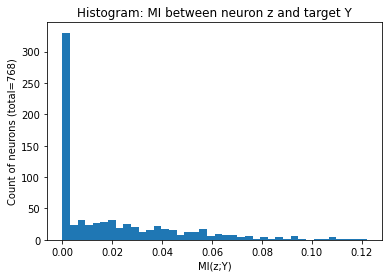

Histogram ignores 304 (39.58%) neurons with 0 values


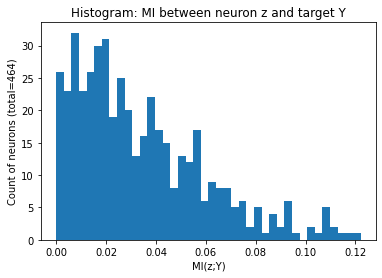

Histogram ignores 304 (39.58%) neurons with 0 values


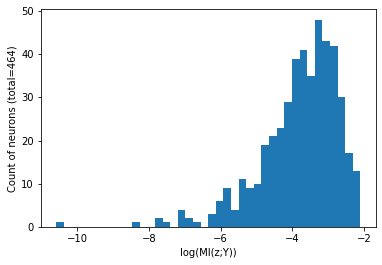

In [15]:
def encode_data(sampled, layer_id, loc_id):
    text = [item['X'] for item in sampled] 
    labels = [item['y'] for item in sampled]
    inputs = tokenizer(text, return_tensors="pt", padding=True)
    outputs = model(**inputs)  # This is slow
    targeted_neurons = outputs["hidden_states"][layer_id][:, loc_id, :].detach().numpy()
    return targeted_neurons

def histogram_plot(mis, log=False, ignore_zero=False):
    plt.figure()
    if ignore_zero:
        pos_mis = mis[mis>0]
        print("Histogram ignores {} ({:.2f}%) neurons with 0 values".format(
            len(mis)-len(pos_mis),
            100.0 * (len(mis)-len(pos_mis)) / len(mis)
        ))
        mis = pos_mis
    if log:
        assert ignore_zero, "Log doesn't handle zero values!"
        xs = np.log(mis)
        plt.hist(xs, bins=40)
        plt.xlabel("log(MI(z;Y))")
        plt.ylabel("Count of neurons (total={})".format(len(mis)))
    else:
        xs = mis
        plt.hist(xs, bins=40)
        plt.xlabel("MI(z;Y)")
        plt.ylabel("Count of neurons (total={})".format(len(mis)))
        plt.title("Histogram: MI between neuron z and target Y")
    plt.show()

sampled, df_sampled = stratify_sample(all_data, [item['y'] for item in all_data], 100, rs=0)
targeted_neurons = encode_data(sampled, layer_id=5, loc_id=0)
stats, mis = compute_mi_statistics(targeted_neurons, [item['y'] for item in sampled], export_all=True)
print(stats)
histogram_plot(mis)
histogram_plot(mis, ignore_zero=True)
histogram_plot(mis, log=True, ignore_zero=True)

Random seed = 0
Histogram ignores 297 (38.67%) neurons with 0 values


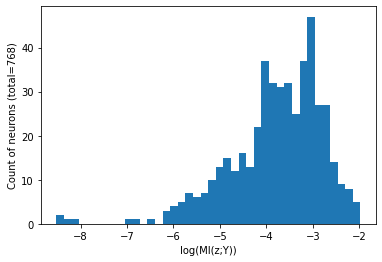

Random seed = 1
Histogram ignores 323 (42.06%) neurons with 0 values


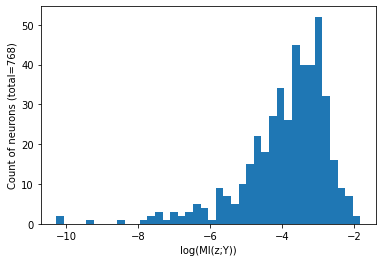

Random seed = 2
Histogram ignores 356 (46.35%) neurons with 0 values


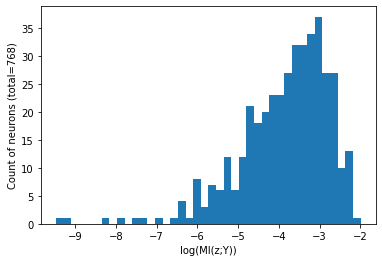

Random seed = 31
Histogram ignores 319 (41.54%) neurons with 0 values


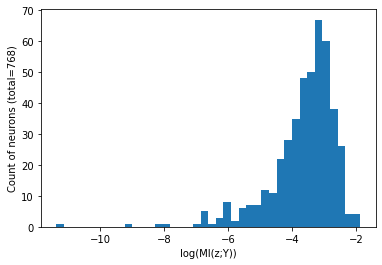

Random seed = 32767
Histogram ignores 306 (39.84%) neurons with 0 values


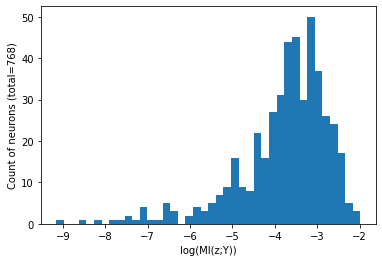

,min,max,mean,std,quantile_10,quantile_90,seed
0,0.0,0.137785,0.020069,0.02519,0.0,0.055718,32767


In [10]:
# Test the reliability across seeds
def test_reliability_across_seeds():
    report = {}
    for rs in [0,1,2,31,32767]:
        print("Random seed = {}".format(rs))
        sampled, df_sampled = stratify_sample(all_data, [item['y'] for item in all_data], 100, rs=rs)
        targeted_neurons = encode_data(sampled, layer_id=1, loc_id=0)
        st, mis = compute_mi_statistics(targeted_neurons, [item['y'] for item in sampled], export_all=True)
        histogram_plot(mis, log=True)
        st["seed"] = rs
    for k in st:
        if k not in report:
            report[k] = [st[k]]
        else:
            report[k].append(st[k])
    
    return pd.DataFrame(report)

test_reliability_across_seeds()

In [16]:
def test_trends_across_layers():
    report = {}
    for rs in [0, 1, 2, 31, 32767]:
        sampled, df_sampled = stratify_sample(all_data, [item['y'] for item in all_data], 50, rs=rs)
        text = [item['X'] for item in sampled] 
        labels = [item['y'] for item in sampled]
        inputs = tokenizer(text, return_tensors="pt", padding=True)
        outputs = model(**inputs)  # This is slow
        hidden_states = [outputs["hidden_states"][layer_id].detach().numpy() for layer_id in range(13)]
        for layer_id in tqdm(range(13)):
            loc_id = 0
            targeted_neurons = hidden_states[layer_id][:, loc_id, :]
            st, mis = compute_mi_statistics(targeted_neurons, [item['y'] for item in sampled], export_all=True)
            st["layer"] = layer_id
            st["seed"] = rs
            st["pctg_zero"] = (mis==0).sum() / len(mis)
            for k in st:
                if k not in report:
                    report[k] = [st[k]]
                else:
                    report[k].append(st[k])
    return pd.DataFrame(report)

layer_report = test_trends_across_layers()

100%|██████████| 13/13 [00:32<00:00,  2.47s/it]


Text(0.5, 1.0, 'Percentage of zero neurons by layer')

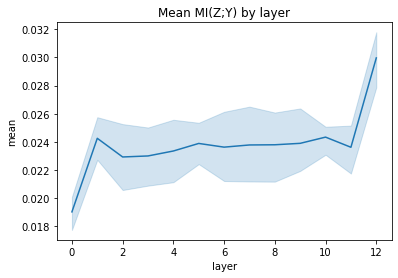

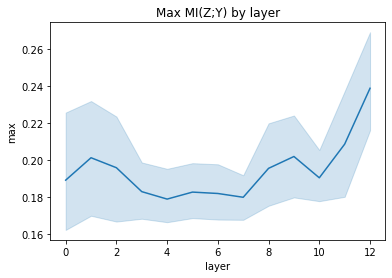

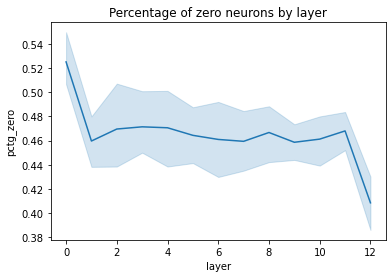

In [17]:
sns.lineplot(data=layer_report, x="layer", y="mean")
plt.title("Mean MI(Z;Y) by layer")
plt.figure()
sns.lineplot(data=layer_report, x="layer", y="max")
plt.title("Max MI(Z;Y) by layer")
plt.figure()
sns.lineplot(data=layer_report, x="layer", y="pctg_zero")
plt.title("Percentage of zero neurons by layer")

In [18]:
class Trainer:
    def __init__(self, X, Y, split="70-15-15"):
        # Since all neurons (X, Y) are selected according to MI that are
        # computed by all data in the sample, I doubt whether choices of
        # the split matter. 
        if split == "70-15-15":
            X_tv, self.X_test, Y_tv, self.Y_test = \
                train_test_split(X, Y, test_size=0.15, stratify=Y)
            self.X_train, self.X_dev, self.Y_train, self.Y_dev = \
                train_test_split(X_tv, Y_tv, test_size=0.176, stratify=Y_tv)
            
    def probe(self):
        models = {
            "LogReg": LogisticRegression(),
            "MLP-10": MLPClassifier([10]),
            "MLP-20": MLPClassifier([20])
        }
        best_scores, best_model_key = [0, 0, 0], "None"
        
        for model_key in models:
            classifier = models[model_key]
            
            classifier.fit(self.X_train, self.Y_train)
            tr_pred = classifier.predict(self.X_train)
            tr_acc = accuracy_score(self.Y_train, tr_pred)
            
            val_pred = classifier.predict(self.X_dev)
            val_acc = accuracy_score(self.Y_dev, val_pred)
            
            ypred = classifier.predict(self.X_test)
            test_acc = accuracy_score(self.Y_test, ypred)
            if val_acc > best_scores[1]:
                best_scores = [tr_acc, val_acc, test_acc]
                best_model_key = model_key
            
        return {
            "train_acc": best_scores[0],
            "val_acc": best_scores[1],
            "test_acc": best_scores[2],
            "best_probe": best_model_key
        }

def test_probing_accuracy(layer_id, rs_list=[0,1,2,31,32767]):
    """
    Compare three settings: (A) use full neurons; (B) only those with MI=0; (C) only those with MI>0
    """
    report = {
        "rs": [],
        "train_acc": [],
        "val_acc": [],
        "test_acc": [],
        "best_probe": [],
        "config": []  # Full / Nonzero / ZeroMI
    }
    for rs in tqdm(rs_list):
        sampled, df_sampled = stratify_sample(all_data, [item['y'] for item in all_data], 100, rs)
        targeted_neurons = encode_data(sampled, layer_id, loc_id=0)  # (bsz, D)
        labels = np.array([item['y'] for item in sampled]).astype(int)
        stats, mis = compute_mi_statistics(
            targeted_neurons, labels, export_all=True)
        nonzero_neurons = targeted_neurons[:, mis>0]
        zero_mi_neurons = targeted_neurons[:, mis==0]

        # Three classifiers
        configs = {
            "Full": Trainer(targeted_neurons, labels),
            "Nonzero": Trainer(nonzero_neurons, labels),
            "ZeroMI": Trainer(zero_mi_neurons, labels)
        }
        for c in configs:
            trainer = configs[c]
            rep = trainer.probe()
            report["rs"].append(rs)
            report["config"].append(c)
            for k in rep:
                report[k].append(rep[k])
    return pd.DataFrame(report)

probing_reports = []
for layer in range(13):
    rep = test_probing_accuracy(layer)
    rep["layer"] = [layer] * len(rep)
    probing_reports.append(rep)
all_layers_report = pd.concat(probing_reports, axis=0)
all_layers_report.to_csv("acc_report.csv", index=False)
all_layers_report

100%|██████████| 5/5 [03:05<00:00, 37.19s/it]


,rs,train_acc,val_acc,test_acc,best_probe,config,layer
0,0,0.500000,0.500000,0.500000,LogReg,Full,0
1,0,0.500000,0.500000,0.500000,LogReg,Nonzero,0
2,0,0.500000,0.500000,0.500000,LogReg,ZeroMI,0
3,1,0.500000,0.500000,0.500000,LogReg,Full,0
4,1,0.500000,0.500000,0.500000,LogReg,Nonzero,0
...,...,...,...,...,...,...,...
10,31,0.871429,0.833333,0.833333,MLP-10,Nonzero,12
11,31,0.821429,0.800000,0.633333,MLP-10,ZeroMI,12
12,32767,0.871429,0.866667,0.900000,LogReg,Full,12
13,32767,0.864286,0.800000,0.866667,LogReg,Nonzero,12


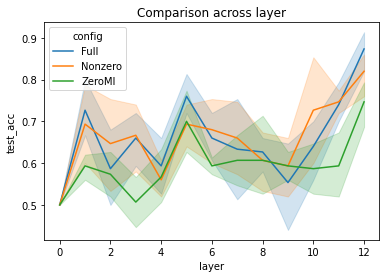

In [19]:
sns.lineplot(x="layer", y="test_acc", data=all_layers_report, hue="config")
plt.title("Comparison across layer")
plt.savefig("acc_report_plot.svg")

In [14]:
from scipy.stats import ttest_1samp, ttest_ind

def stats_tests(df):
    for layer in range(13):
        print("="*10 + f" Layer {layer} " + "="*10)
        dft = df[df.layer == layer]
        
        tval_f, pval_f = ttest_1samp(dft[dft.config=="Full"].test_acc, 0.5)
        tval_n, pval_n = ttest_1samp(dft[dft.config=="Nonzero"].test_acc, 0.5)
        tval_z, pval_z = ttest_1samp(dft[dft.config=="ZeroMI"].test_acc, 0.5)
        print("Better than trivial? Full: {}, Nonzero: {}, ZeroMI: {}".format(
            pval_f < 0.05, pval_n < 0.05, pval_z < 0.05
        ))
        
        # Test if config="full" or "nonzero" is better than config="zeroMI"
        tval_f, pval_f = ttest_ind(dft[dft.config=="Full"].test_acc, dft[dft.config=="ZeroMI"].test_acc, equal_var=False)
        tval_n, pval_n = ttest_ind(dft[dft.config=="Nonzero"].test_acc, dft[dft.config=="ZeroMI"].test_acc, equal_var=False)
        print("Better than ZeroMI? Full: {}, Nonzero: {}".format(
            pval_f < 0.05, pval_n < 0.05
        ))
        
all_layers_report = pd.read_csv("acc_report_1.csv")
stats_tests(all_layers_report)

========== Layer 0 ==========
Better than trivial? Full: False, Nonzero: False, ZeroMI: False
Better than ZeroMI? Full: False, Nonzero: False
========== Layer 1 ==========
Better than trivial? Full: True, Nonzero: True, ZeroMI: False
Better than ZeroMI? Full: False, Nonzero: False
========== Layer 2 ==========
Better than trivial? Full: True, Nonzero: True, ZeroMI: False
Better than ZeroMI? Full: False, Nonzero: False
========== Layer 3 ==========
Better than trivial? Full: False, Nonzero: True, ZeroMI: False
Better than ZeroMI? Full: False, Nonzero: True
========== Layer 4 ==========
Better than trivial? Full: False, Nonzero: False, ZeroMI: False
Better than ZeroMI? Full: False, Nonzero: False
========== Layer 5 ==========
Better than trivial? Full: True, Nonzero: True, ZeroMI: False
Better than ZeroMI? Full: False, Nonzero: True
========== Layer 6 ==========
Better than trivial? Full: True, Nonzero: True, ZeroMI: False
Better than ZeroMI? Full: False, Nonzero: False
========== Layer 

Some observations from the `acc_report_1.csv` (no stratified train/val/test split):  
1. Except for the last layer, the ZeroMI config is not better than trivial (0.5 acc)  
2. Except for layer 3 (Nonzero) and layer 12 (ZeroMI), in other configs, ZeroMI and Nonzero are **not** better than ZeroMI  

Let's see if these observations still hold for the `acc_report.csv` (with stratified train/val/test split):  
1. ZeroMI config *can* be better than trivial.  
2. Some of Full (layer 3, 11, 12) and Nonzero (layer 3, 11) are better than ZeroMI.  

In [20]:
all_layers_report = pd.read_csv("acc_report.csv")
stats_tests(all_layers_report)

========== Layer 0 ==========
Better than trivial? Full: False, Nonzero: False, ZeroMI: False
Better than ZeroMI? Full: False, Nonzero: False
========== Layer 1 ==========
Better than trivial? Full: True, Nonzero: True, ZeroMI: True
Better than ZeroMI? Full: True, Nonzero: False
========== Layer 2 ==========
Better than trivial? Full: False, Nonzero: False, ZeroMI: False
Better than ZeroMI? Full: False, Nonzero: False
========== Layer 3 ==========
Better than trivial? Full: True, Nonzero: True, ZeroMI: False
Better than ZeroMI? Full: True, Nonzero: True
========== Layer 4 ==========
Better than trivial? Full: False, Nonzero: False, ZeroMI: False
Better than ZeroMI? Full: False, Nonzero: False
========== Layer 5 ==========
Better than trivial? Full: True, Nonzero: True, ZeroMI: True
Better than ZeroMI? Full: False, Nonzero: False
========== Layer 6 ==========
Better than trivial? Full: True, Nonzero: True, ZeroMI: True
Better than ZeroMI? Full: False, Nonzero: False
========== Layer 7 =